In [1]:
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

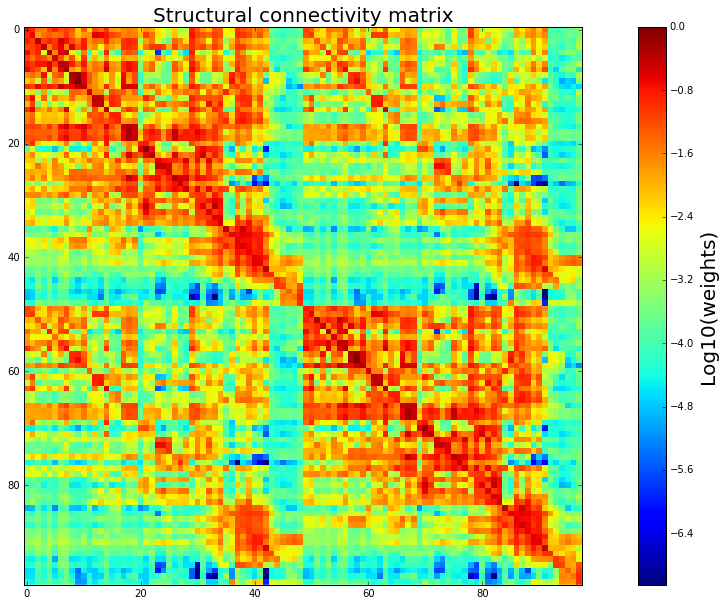

In [3]:
# Load the connectivity data from the directory tvb_data
con = connectivity.Connectivity.from_file("../mouse/Connectome_Allen_2mm/Connectome_Allen_2mm.zip")

# Visualize the structural connectivity matrix
plt.subplots()
LSC=np.log10(con.weights)
LSC[LSC==-float('inf')]=10
LSC[LSC==10]=np.amin(LSC)
cs=plt.imshow(LSC, cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)


In [4]:
# Set the parameter of the resting state simulation
sim = simulator.Simulator(model=models.ReducedWongWang(w=1.0, I_o=0.3),
                        connectivity=con,
                        coupling=coupling.Linear(a=0.096),
                        integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=0.000013)),
                        monitors=(monitors.Bold(period=2e3),
                                  monitors.TemporalAverage(period=1e3)),
                        simulation_length=1200e3).configure()
# Run the resting state simulation
(bold_time, bold_data), _ = sim.run()

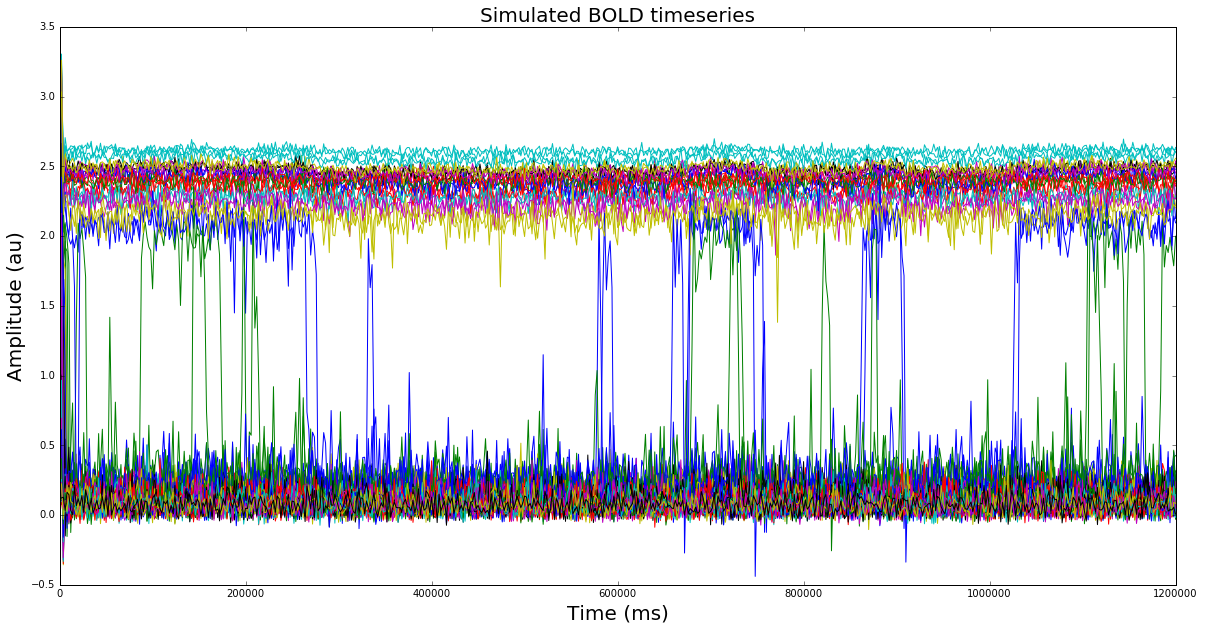

In [14]:
# Display the simulated bold timeseries
plt.subplots()
plt.plot(bold_time,bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)

In [6]:
## Calculate the FCD matrix for the bold timeseries

import tvb.analyzers.fcd_matrix as fcd
from tvb.datatypes.time_series import TimeSeriesRegion

# Build the time series object
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data,
                       sample_period=sim.monitors[0].period)
tsr.configure()

# Create and evaluate the analysis
wind_len=180e3 # windows length (ms)
wind_sp=4e3 # spanning between sliding windows (ms)
fcd_analyser = fcd.FcdCalculator(time_series=tsr, sw=wind_len, sp=wind_sp)
fcd_data = fcd_analyser.evaluate()

# Store the results
FCD=fcd_data[0][:,:,0,0]
FCD_segmented=fcd_data[1][:,:,0,0]
Eigvect_dict=fcd_data[2]
Eigval_dict=fcd_data[3]

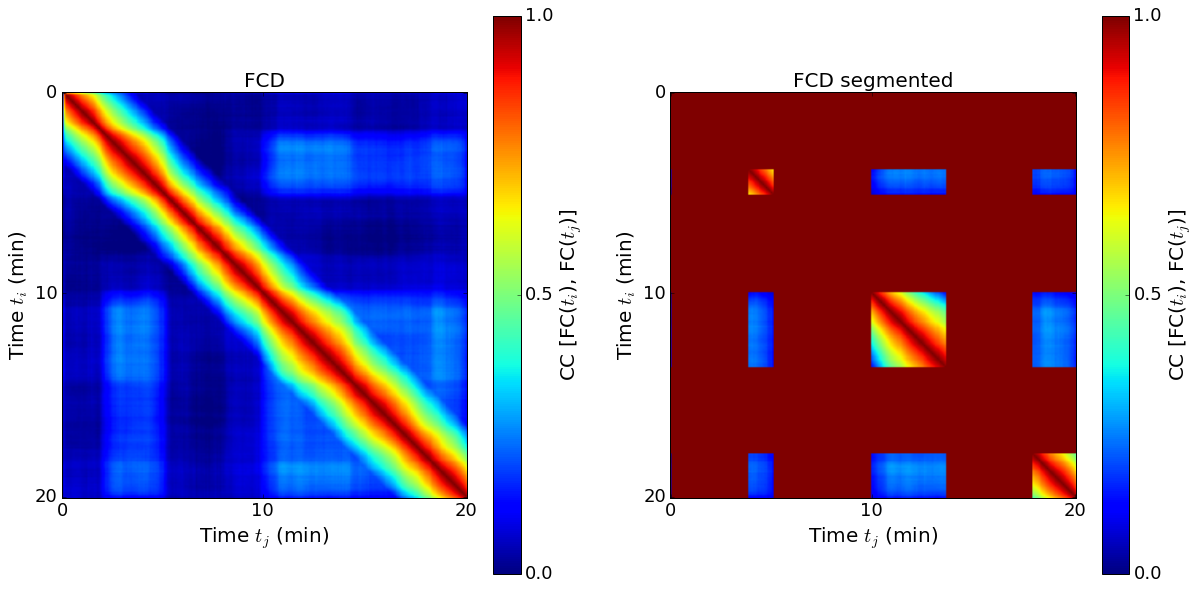

In [7]:
# Plot the FCD matrix and the FCD matrix segmented in the epochs
plt.subplot(121)
cs=plt.imshow(FCD, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD', fontsize=20)

plt.subplot(122)
cs=plt.imshow(FCD_segmented, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','10', '20'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD segmented', fontsize=20)

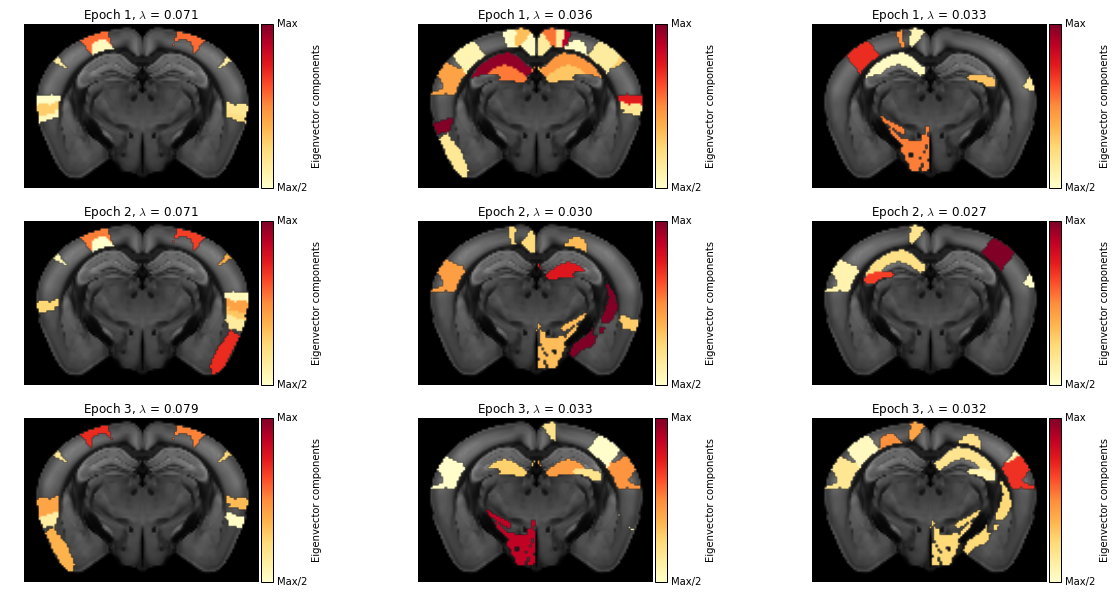

In [13]:
# Plot the functional hubs extracted in the epochs

import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tvb.basic.readers import try_get_absolute_path

fig, axes = plt.subplots(3,3)

mode=0
var=0
count=1
slice_idy=73
for ep in range(3):
    for eigval in range(3):
        f_path = try_get_absolute_path("tvb_data", "mouse/Connectome_Allen_2mm/RegionVolumeMapping.h5")
        print "trying to read ", f_path
        f = h5py.File(f_path, 'r', libver='latest')
        Vol=f['array_data'][:,:,:]
        f_path = try_get_absolute_path("tvb_data", "mouse/Connectome_Allen_2mm/StructuralMRI.h5")
        f = h5py.File(f_path, 'r', libver='latest')
        template=f['array_data'][:,:,:]
        lambda_=Eigval_dict[mode][var][ep+1][eigval]
        eig=Eigvect_dict[mode][var][ep+1][eigval] 

        for i in range(np.shape(eig)[0]):
            Vol[Vol==i]=eig[i]
        Vol = np.ma.masked_where(Vol < (np.amax(eig)/2), Vol)        
        im1 = axes[ep,eigval].imshow((template[:,slice_idy,:].T)[::-1], cmap='gray', vmin=template.min(), vmax=template.max())
        cax = axes[ep,eigval].imshow((Vol[:,slice_idy,:].T)[::-1], cmap='YlOrRd', alpha=1, vmin=np.amax(eig)/2., vmax=np.amax(eig))
        axes[ep,eigval].axis('off')
        axes[ep,eigval].set_title(r'Epoch %s, $\lambda$ = %1.3f'%(ep+1,lambda_))
        divider = make_axes_locatable(axes[ep,eigval])
        cax1 = divider.append_axes("right", size="5%", pad=0.05)
        axcb=plt.colorbar(cax,cax1,ticks=[np.amax(eig)/2.,np.amax(eig)],orientation='vertical')
        axcb.set_ticklabels(['Max/2', 'Max']) 
        axcb.set_label('Eigenvector components')